In [1]:
from src.models.unet.unet_model import UNet
from torch.utils.data import DataLoader
import torch
from src.datasets.ice import Ice
from torch import nn
import os
import matplotlib.pyplot as plt
import numpy as np
from src.metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index, fw_miou
from src.metrics.river_ice_metrics import pixel_accuracy, mean_accuracy, mean_IU, frequency_weighted_IU
import json

def load_json_metrics(file_path):
    with open(file_path, 'r') as fp:
        metrics = json.load(fp)
    return metrics

In [2]:
unet_acc = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/original_test/honest_salad_428_unet_ice_original_split-mean-acc-epoch.json')
unet_iou = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/original_test/honest_salad_428_unet_ice_original_split-mean-iou-epoch.json')

small_dsc_lbc_unet_acc = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/original_test/peach_glitter_436_skinny_dsc_lbc_ice_original_split-mean-acc-epoch.json')
small_dsc_lbc_unet_iou = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/original_test/peach_glitter_436_skinny_dsc_lbc_ice_original_split-mean-iou-epoch.json')

lraspp_acc = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/original_test/fresh_vally_433_lraspp_mobilenet_ice_original_split-mean-acc-epoch.json')
lraspp_iou = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/original_test/fresh_vally_433_lraspp_mobilenet_ice_original_split-mean-iou-epoch.json')

small_dsc_lbc_unet_acc_2 = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/original_test/lilac_sky_429_skinny_dsc_lbc_unet_ice_original_split-mean-acc-epoch.json')
small_dsc_lbc_unet_iou_2 = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/original_test/lilac_sky_429_skinny_dsc_lbc_unet_ice_original_split-mean-iou-epoch.json')



In [3]:
print(str(np.argmax([x[-1] for x in small_dsc_lbc_unet_acc_2.values()])+1))
print(small_dsc_lbc_unet_acc_2[str(np.argmax([x[-1] for x in small_dsc_lbc_unet_acc_2.values()])+1)])
print(str(np.argmax([x[-1] for x in small_dsc_lbc_unet_iou_2.values()])+1))
print(small_dsc_lbc_unet_iou_2[str(np.argmax([x[-1] for x in small_dsc_lbc_unet_iou_2.values()])+1)])

76
[0.7361632129078355, 0.8108136913655103, 0.8413322638771347, 0.8890177408854166]
80
[0.5041056302110035, 0.6651980459446966, 0.7032073312688454, 0.8252012665454984]


In [12]:
print(str(np.argmax([x[-1] for x in unet_acc.values()])+1))
print(unet_acc[str(np.argmax([x[-1] for x in unet_acc.values()])+1)])
print(str(np.argmax([x[-1] for x in unet_iou.values()])+1))
print(unet_iou[str(np.argmax([x[-1] for x in unet_iou.values()])+1)])

45
[0.8003096247953627, 0.8385836292312956, 0.872153295610859, 0.8934945000542535]
45
[0.53693255002208, 0.7086892310755593, 0.7286617257773718, 0.8296470932632322]


In [6]:
# print(str(np.argmax([x[-1] for x in small_dsc_lbc_unet_acc.values()])+1))
print(small_dsc_lbc_unet_acc[str(60+1)])
# print(str(np.argmax([x[-1] for x in small_dsc_lbc_unet_iou.values()])+1))
print(small_dsc_lbc_unet_iou[str(60+1)])

[0.6987935372801742, 0.9217072252400763, 0.8635860176278177, 0.9063652886284722]
[0.5429683394703424, 0.7368068710928434, 0.7421923964037128, 0.8455216793229684]


In [15]:
print(str(np.argmax([x[-1] for x in lraspp_acc.values()])+1))
print(lraspp_acc[str(np.argmax([x[-1] for x in lraspp_iou.values()])+1)])
print(str(np.argmax([x[-1] for x in lraspp_iou.values()])+1))
print(lraspp_iou[str(np.argmax([x[-1] for x in lraspp_iou.values()])+1)])

77
[0.7734975602955966, 0.8022025621529612, 0.8432337339672566, 0.8699018690321181]
63
[0.48499806886371616, 0.6582220121970751, 0.6829101442955988, 0.7953994812638029]


In [4]:
i

17

In [3]:
net = UNet(n_channels=3, n_classes=3, bilinear=True)
checkpoint = 'frosty_sponge_239_unet_ice'
data_dir = '/home/dsola/repos/PGA-Net/data/'
batch_size = 1
img_scale = 0.35
img_crop = 256
epoch = 31

test_set = Ice(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
              os.path.join(data_dir, 'txt_files'), 'val', img_scale, img_crop)

test_loader = DataLoader(test_set, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net.to(device=device)

checkpoint_path = f'/home/dsola/repos/PGA-Net/checkpoints/{checkpoint}/epoch{epoch + 1}.pth'
net.load_state_dict(torch.load(checkpoint_path, map_location=device))
net.train()
out = nn.Softmax(dim=1)

avg_mean_IU_ice = avg_mean_IU_ice_1 = avg_mean_IU_ice_2 = 0
avg_mean_acc_ice = avg_mean_acc_ice_1 = avg_mean_acc_ice_2 = 0
fw_iou_list, mean_iu_list = [], []

for i, batch in enumerate(test_loader):
    img = batch['image'].to(device=device)
    mask = batch['mask'].to(device=device, dtype=torch.long)

    with torch.no_grad():
        output = net(img)
    sftmx = out(output)
    argmx = torch.argmax(sftmx, dim=1)
    
    im = img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]
    pred = argmx.squeeze(0).detach().cpu().numpy()
    gt = mask.squeeze(0).squeeze(0).detach().cpu().numpy()
    
    fw_iou = frequency_weighted_IU(pred, gt)
    fw_iou_list.append(fw_iou)
    
    mean_iu = mean_IU(pred, gt)
    mean_iu_list.append(mean_iu)
    
    _acc, _ = mean_accuracy(pred, gt, return_acc=1)
    mean_acc_ice = np.mean(list(_acc.values())[1:])
    avg_mean_acc_ice += (mean_acc_ice - avg_mean_acc_ice) / (i + 1)
    mean_acc_ice_1 = _acc[1]
    avg_mean_acc_ice_1 += (mean_acc_ice_1 - avg_mean_acc_ice_1) / (i + 1)
    mean_acc_ice_2 = _acc[2]
    avg_mean_acc_ice_2 += (mean_acc_ice_2 - avg_mean_acc_ice_2) / (i + 1)
    
    _IU, _ = mean_IU(pred, gt, return_iu=1)
    mean_IU_ice = np.mean(list(_IU.values())[1:])
    avg_mean_IU_ice += (mean_IU_ice - avg_mean_IU_ice) / (i + 1)
    mean_IU_ice_1 = _IU[1]
    avg_mean_IU_ice_1 += (mean_IU_ice_1 - avg_mean_IU_ice_1) / (i + 1)
    mean_IU_ice_2 = _IU[2]
    avg_mean_IU_ice_2 += (mean_IU_ice_2 - avg_mean_IU_ice_2) / (i + 1)
    
#     print(avg_mean_acc_ice, avg_mean_acc_ice_1, avg_mean_acc_ice_2)
#     print(avg_mean_IU_ice, avg_mean_IU_ice_1, avg_mean_IU_ice_2)

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


IsADirectoryError: [Errno 21] Is a directory: '/home/dsola/repos/PGA-Net/data/imgs/'

In [5]:
print(avg_mean_IU_ice_1, avg_mean_IU_ice_2)
print(np.mean(mean_iu_list))
print(np.mean(fw_iou_list))
# print(avg_mean_acc_ice_1, avg_mean_acc_ice_2)


0.5286541856003766 0.6852227421790984
0.7167126677770209
0.822468074171416


In [2]:
net = UNet(n_channels=3, n_classes=3, bilinear=True)
checkpoint = 'frosty_sponge_239_unet_ice'
data_dir = '/home/dsola/repos/PGA-Net/data/'
batch_size = 1
img_scale = 0.35
img_crop = 256
epoch = 40

test_set = Ice(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
              os.path.join(data_dir, 'txt_files'), 'val', img_scale, img_crop)

test_loader = DataLoader(test_set, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net.to(device=device)

checkpoint_path = f'/home/dsola/repos/PGA-Net/checkpoints/{checkpoint}/epoch{epoch + 1}.pth'
net.load_state_dict(torch.load(checkpoint_path, map_location=device))
net.train()
out = nn.Softmax(dim=1)

batch = test_set[0]

img = batch['image'].to(device=device).unsqueeze(0)
mask = batch['mask'].to(device=device, dtype=torch.long).unsqueeze(0)

with torch.no_grad():
    output = net(img)
sftmx = out(output)
argmx = torch.argmax(sftmx, dim=1)

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [3]:
im = img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]
pred = argmx.squeeze(0).detach().cpu().numpy()
gt = mask.squeeze(0).squeeze(0).detach().cpu().numpy()

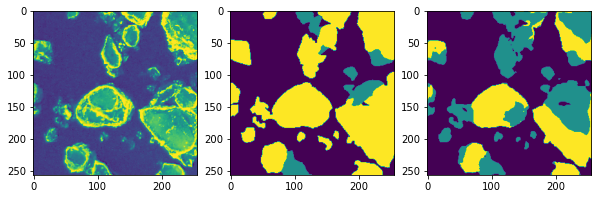

In [4]:
fig, axs = plt.subplots(1,3, figsize=(10,10))
axs[0].imshow(im)
axs[1].imshow(gt)
axs[2].imshow(pred)

In [5]:
hist = _fast_hist(mask.squeeze(0), argmx.to(dtype=torch.long), 3)
iou = jaccard_index(hist)
acc = per_class_pixel_accuracy(hist)
fw_iou, class_scores = fw_miou(hist)

In [7]:
print(fw_iou, class_scores)

tensor(0.7867, device='cuda:0') tensor([35023.,  3554., 12982.])


In [8]:
iou

(tensor(0.5522, device='cuda:0'),
 tensor([0.9382, 0.2212, 0.4971], device='cuda:0'))

In [9]:
acc

(tensor(0.7909, device='cuda:0'),
 tensor([0.9838, 0.8883, 0.5005], device='cuda:0'))

In [10]:
mean_accuracy(pred, gt, return_acc=1)

({0: 0.9838474071577055, 1: 0.8882779305173707, 2: 0.5005204919612908},
 0.7908819432121224)

In [11]:
pixel_accuracy(pred, gt)

0.7867279052734375

In [5]:
mean_IU(pred, gt, return_iu=1)

({0: 0.8575595144253508, 1: 0.5091007000538503, 2: 0.5911455366974219},
 0.6526019170588743)

In [13]:
gt_0 = (gt==0)*1
pred_0 = (pred==0)*1
gt_1 = (gt==1)*1
pred_1 = (pred==1)*1
gt_2 = (gt==2)*1
pred_2 = (pred==2)*1

In [14]:
frequency_weighted_IU(pred_0, gt_0)

0.9318925776884694

In [15]:
frequency_weighted_IU(pred_1, gt_1)

0.762865620179328

In [16]:
frequency_weighted_IU(pred_2, gt_2)

0.6499962775225224

In [17]:
frequency_weighted_IU(pred, gt, return_freq=1)

(0.7198631621461106, [35598.0, 4001.0, 25937.0])

In [6]:
mean_IU(pred, gt)

0.6526019170588743